#Training a Semantic Segmentation Model for SLZ Detection

### 1- Loading Images:
A combination of 3 datasets will be used: UAVid, ISPRS, and Semantic Drone Dataset. The images are resized to 128x128 for fast processing and are  combined into one folder, DS, with subfolders for images and masks.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q git+https://github.com/keras-team/keras-cv.git --upgrade
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

import os
import requests
from zipfile import ZipFile
import glob
from dataclasses import dataclass, field

import random
import numpy as np
import cv2

import tensorflow as tf
#print ("TensorFlow version",tf,__version__)
import keras_cv
import shutil
import matplotlib.pyplot as plt

#import glob
#import random
#import tensorflow as tf

print ("INFO: importing libraries ... Done.")

# (1) Set Seeds for Reproducibility

print("(1) Set Seeds for Reproducibility")

def system_config(SEED_VALUE):
    # Set python `random` seed.
    # Set `numpy` seed
    # Set `tensorflow` seed.
    random.seed(SEED_VALUE)
    tf.keras.utils.set_random_seed(SEED_VALUE)
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_USE_CUDNN'] = "true"

system_config(SEED_VALUE=42)
print ("INFO: Setting Seeds ... Done.")

# (2) Download and Extract Dataset

print("(2) Download and Extract Dataset")

# Download and dataset.
def download_and_unzip_gdrive(url, save_path, dir):

    print("INFO: Downloading and extracting assets...", end="")
    print("INFO: url:",url)
    print("INFO: save_path:",save_path)
    file = os.path.join("/content/drive/MyDrive", f"{dir}.zip")
    !ls -l $file
    !cp $file .

    try:
        # Specify extraction path dynamically
        extract_path = f'/content/{dir}'  # Use the `dir` name dynamically for extraction folder
        os.makedirs(extract_path, exist_ok=True)

        with ZipFile(save_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

        print(f"Extraction complete for {dir}.")
    except Exception as e:
        print(f"Failed to unzip {save_path}: {e}")

print("INFO: Download/extract dataset ... Done.")

# Download the dataset as a ZIP file from drive to save storage
# List of datasets to process
datasets = [
    # ISPRS aug 128 (DS4-128)
    {"url": "https://drive.google.com/file/d/1f_l9MLQXEyV6kfn4r1exbMoEjj1coK70/view?usp=sharing", "dir": "DS4-128"},

    # semantic drone dataset aug 128 (DS6-128)
    {"url": "https://drive.google.com/file/d/11uHD78s1tRfJw5-FAmhBWlHrBMZogwhU/view?usp=sharing", "dir": "DS6-128"},

    # UAVid aug relabeled 128 (DS7-128)
    {"url": "https://drive.google.com/file/d/1V0QRbNWvr0_EISzXGiUDQyj0TXfuQDtN/view?usp=sharing", "dir": "DS7-128"}
]

target_dir1 = "DS7-128"
target_dir2 = "DS4-128"
target_dir3 = "DS6-128"

# Process each dataset
for dataset in datasets:
    dataset_dir = dataset["dir"]
    dataset_zip_path = os.path.join("/content", f"{dataset_dir}.zip")

    # Skip if dataset already exists
    if not os.path.exists(f'/content/{dataset_dir}'):
        print(f"INFO: Starting download and extraction for {dataset_dir}")
        download_and_unzip_gdrive(dataset["url"], dataset_zip_path, dataset_dir)
    else:
        print(f"INFO: Dataset {dataset_dir} already exists, skipping.")


# Define paths to the folders
folder1 = os.path.join('/content', target_dir1)
folder2 = os.path.join('/content', target_dir2)
folder3 = os.path.join('/content', target_dir3)
merged_folder = '/content/DS'

# Ensure the merged folder exists
os.makedirs(merged_folder, exist_ok=True)

# List of folders to merge
folders_to_merge = [folder1, folder2, folder3]

# Iterate through each source folder
for folder in folders_to_merge:
    if not os.path.exists(folder):
        print(f"Warning: {folder} does not exist. Skipping.")
        continue
    # Iterate through subfolders in the current folder
    for subfolder_name in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder_name)
        target_subfolder_path = os.path.join(merged_folder, subfolder_name)

        # Ensure the target subfolder exists
        os.makedirs(target_subfolder_path, exist_ok=True)

        # Merge the contents of the current subfolder
        if os.path.isdir(subfolder_path):
            for item in os.listdir(subfolder_path):
                src_item = os.path.join(subfolder_path, item)
                dest_item = os.path.join(target_subfolder_path, item)

                # Move or copy files
                if os.path.isfile(src_item):
                    shutil.copy2(src_item, dest_item)
                elif os.path.isdir(src_item):
                    shutil.copytree(src_item, dest_item, dirs_exist_ok=True)

print("Folders merged successfully!")
# DEBUG
print(os.listdir("/content/DS/train_img_processed"))


## 2-Imports and Setting Variables:
This section handles imports needed to create the model and stores variables needed for model training.








In [ ]:
import os
import requests
from zipfile import ZipFile
import glob
from dataclasses import dataclass, field
import random
import numpy as np
import cv2

import tensorflow as tf
import keras_cv
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.utils import Sequence
from scipy.spatial import KDTree

NUM_CLASSES = 7
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
EPOCHS = 150

IMAGE_PATH = '/content/DS/train_img_processed/'
MASK_PATH = '/content/DS/train_mask_processed/'
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 128, 128, 3

id2color = {
    0: (128, 0, 0),
    1: (0, 128, 0),
    2: (128, 128, 0),
    3: (192, 0, 192),
    4: (128, 64, 128),
    5: (64, 64, 0),
    6: (0, 0, 0),
}


## 3-Image Preprocessing:
The class-to-RGB mapping establishes a mapping between segmentation class IDs and RGB color values and ensures proper conversion between pixel colors and class labels. The files are then split randomly, selecting 10% of images for testing while keeping the rest for training. A data loading function is then created to prevent crashing upon execution.

In [ ]:
color2id = {tuple(v): k for k, v in id2color.items()}

def filter_files(files):
    return sorted([f for f in files if f.endswith('.png')])

image_files = filter_files(os.listdir(IMAGE_PATH))
mask_files = filter_files(os.listdir(MASK_PATH))

valid_prefixes = ("geo", "photo", "noise")
filtered_images = [img for img in image_files if img.startswith(valid_prefixes)]
filtered_masks = [mask for img, mask in zip(image_files, mask_files) if img.startswith(valid_prefixes)]

assert len(filtered_images) == len(filtered_masks)

remaining_images = [img for img in image_files if not img.startswith(valid_prefixes)]
remaining_masks = [mask for img, mask in zip(image_files, mask_files) if not img.startswith(valid_prefixes)]

assert len(remaining_images) == len(remaining_masks)

test_size = max(1, int(0.1 * len(image_files)))

random.seed(42)
test_indices = set(random.sample(range(len(image_files)), min(test_size, len(image_files))))

X_test_files = [image_files[i] for i in test_indices]
Y_test_files = [mask_files[i] for i in test_indices]

X_train_files = [image_files[i] for i in range(len(image_files)) if i not in test_indices]
Y_train_files = [mask_files[i] for i in range(len(mask_files)) if i not in test_indices]

assert len(X_train_files) == len(Y_train_files)
assert len(X_test_files) == len(Y_test_files)

print(f"Total images: {len(image_files)}")
print(f"Filtered images count: {len(filtered_images)}")
print(f"Remaining images count: {len(remaining_images)}")
print(f"X_train count: {len(X_train_files)}, Y_train count: {len(Y_train_files)}")
print(f"X_test count: {len(X_test_files)}, Y_test count: {len(Y_test_files)}")

def load_data(image_files, mask_files, image_path, mask_path):
    X_data = []
    Y_data = []

    for i in tqdm(range(len(image_files))):
        img_path = os.path.join(image_path, image_files[i])
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0

        m_path = os.path.join(mask_path, mask_files[i])
        mask = imread(m_path)

        if mask.shape[-1] == 4:
            mask = mask[..., :3]

        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True).astype(np.uint8)

        class_id_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
        for class_id, color in id2color.items():
            class_id_mask[np.all(mask == color, axis=-1)] = class_id

        X_data.append(img)
        Y_data.append(tf.keras.utils.to_categorical(class_id_mask, num_classes=NUM_CLASSES))

    return np.array(X_data), np.array(Y_data)

train_loader = load_data(X_train_files, Y_train_files, IMAGE_PATH, MASK_PATH)
test_loader = load_data(X_test_files, Y_test_files, IMAGE_PATH, MASK_PATH)

Total images: 2920
Filtered images count: 2190
Remaining images count: 730
X_train count: 2628, Y_train count: 2628
X_test count: 292, Y_test count: 292


100%|██████████| 292/292 [00:03<00:00, 76.73it/s]


## 4-Model Setup:
Defines a U-Net architecture with MobileNetV2 as the encoder. Includes skip connections, transposed convolutions, and batch normalization for better feature learning. Produces a multi-class segmentation mask using a softmax activation layer and ensures compatibility with categorical cross-entropy loss during training.

In [ ]:

def unet_mobilenet(input_shape, num_classes):
    inputs = Input(shape=input_shape, dtype='float32')
    base_model = MobileNetV2(input_tensor=inputs, weights='imagenet', include_top=False, alpha=1.0)

    for layer in base_model.layers[-30:]:
        layer.trainable = True

    encoder_output = base_model.get_layer('block_13_expand_relu').output
    skip_1 = base_model.get_layer('block_1_expand_relu').output
    skip_2 = base_model.get_layer('block_3_expand_relu').output
    skip_3 = base_model.get_layer('block_6_expand_relu').output

    u1 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', dtype='float32')(encoder_output)
    u1 = concatenate([u1, skip_3])
    u1 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-3))(u1)
    u1 = Dropout(0.4)(u1)
    u1 = BatchNormalization()(u1)

    u2 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', dtype='float32')(u1)
    u2 = concatenate([u2, skip_2])
    u2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-3))(u2)
    u2 = Dropout(0.3)(u2)
    u2 = BatchNormalization()(u2)

    u3 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', dtype='float32')(u2)
    u3 = concatenate([u3, skip_1])
    u3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-3))(u3)
    u3 = Dropout(0.2)(u3)
    u3 = BatchNormalization()(u3)

    u4 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', dtype='float32')(u3)
    u4 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-3))(u4)
    u4 = Dropout(0.1)(u4)
    u4 = BatchNormalization()(u4)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax', dtype='float32')(u4)

    return Model(inputs, outputs)


### Displays test image

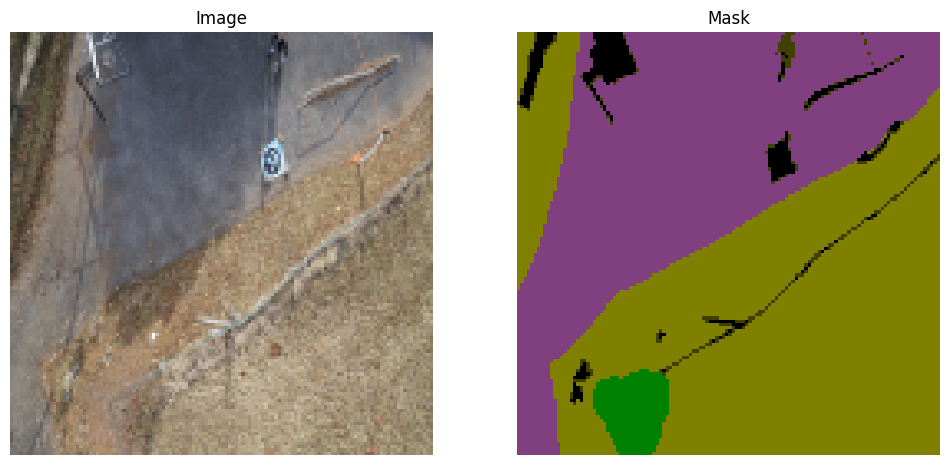

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display image and its mask
def display_image_and_mask(image, mask, class_id_mask):
    """
    Displays an image and its corresponding mask with the class color map.

    Arguments:
    - image: The image (RGB format)
    - mask: The mask (one-hot encoded)
    - class_id_mask: The class ID mask (used to map the colors)
    """
    plt.figure(figsize=(12, 6))

    # Plot Image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis('off')

    # Plot Mask (using the class_id_mask to get the color mapping)
    plt.subplot(1, 2, 2)
    # Convert the one-hot encoded mask back to RGB for display
    mask_rgb = np.argmax(mask, axis=-1)
    mask_rgb = np.stack([id2color[cls] for cls in mask_rgb.flatten()], axis=0)
    mask_rgb = mask_rgb.reshape((IMG_HEIGHT, IMG_WIDTH, 3))  # Reshape to the image size
    plt.imshow(mask_rgb)
    plt.title("Mask")
    plt.axis('off')

    plt.show()

# Select a random index from the train set
random_idx = np.random.randint(0, len(X_train_files))

# Load the image and its corresponding mask
image = train_loader[0][random_idx]
mask = train_loader[1][random_idx]

# Convert one-hot encoded mask back to class IDs
class_id_mask = np.argmax(mask, axis=-1)

# Display image and mask
display_image_and_mask(image, mask, class_id_mask)


##5-Model Training:
The code optimizes U-Net training with EarlyStopping, Exponential Decay learning rate, and AdamW optimizer. EarlyStopping halts training if validation loss doesn’t improve for 30 epochs, restoring the best weights. The learning rate decays by 0.9 every 10,000 steps, applied via AdamW, which also includes weight decay to prevent overfitting.

A BatchSizeScheduler logs suggested batch size reductions every 10 epochs, though it cannot dynamically adjust training. The model is compiled with Categorical Crossentropy for multi-class segmentation and trained using model.fit() with callbacks for early stopping and batch size logging, while AdamW handles learning rate adjustments.










In [ ]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# EarlyStopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    min_delta=0.0001,
    verbose=1,
    restore_best_weights=True
)

# Learning Rate Scheduler using Exponential Decay
lr_schedule = ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,  # Define LEARNING_RATE beforehand
    decay_steps=10000,  # Adjust based on dataset size
    decay_rate=0.9,
    staircase=True  # If True, decay occurs at discrete intervals
)

# Optimizer with Learning Rate Scheduler
optimizer = AdamW(learning_rate=lr_schedule, weight_decay=WEIGHT_DECAY)

# BatchSizeScheduler class (Still not dynamically adjustable during training)
class BatchSizeScheduler(Callback):
    def __init__(self, initial_batch_size, batch_size_decay_epoch=10, batch_size_factor=2):
        super().__init__()
        self.initial_batch_size = initial_batch_size
        self.batch_size_decay_epoch = batch_size_decay_epoch
        self.batch_size_factor = batch_size_factor

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.batch_size_decay_epoch == 0:
            new_batch_size = self.initial_batch_size // self.batch_size_factor
            print(f"\nEpoch {epoch + 1}: Suggested batch size reduction to {new_batch_size}")
            # Keras doesn't support dynamic batch size changes, so we log it.

# Initialize batch size scheduler
batch_size_scheduler = BatchSizeScheduler(initial_batch_size=BATCH_SIZE)

# Create U-Net model
model = unet_mobilenet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), NUM_CLASSES)

# Compile the model
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model with early stopping and batch size scheduler
history = model.fit(
    train_loader[0], train_loader[1],
    validation_data=(test_loader[0], test_loader[1]),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, batch_size_scheduler],  # LR scheduler handled inside AdamW
    verbose=1
)


<ipython-input-2-fca2d682a697>:152: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=inputs, weights='imagenet', include_top=False, alpha=1.0)


Epoch 1/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 87s 469ms/step - accuracy: 0.2517 - loss: 2.7431 - val_accuracy: 0.4393 - val_loss: 2.3504
Epoch 2/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.5677 - loss: 1.7003 - val_accuracy: 0.5549 - val_loss: 1.7443
Epoch 3/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.6431 - loss: 1.4264 - val_accuracy: 0.5903 - val_loss: 1.5631
Epoch 4/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.6932 - loss: 1.2492 - val_accuracy: 0.5850 - val_loss: 1.5587
Epoch 5/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.7286 - loss: 1.1256 - val_accuracy: 0.5871 - val_loss: 1.5933
Epoch 6/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.7530 - loss: 1.0329 - val_accuracy: 0.6092 - val_loss: 1.5269
Epoch 7/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.7707 - loss: 0.9615 - val_accuracy: 0.6343 - val_loss: 1.4007
Epoch 8/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.7857 - loss: 0.9008 - 

### Display Training Results on Graph

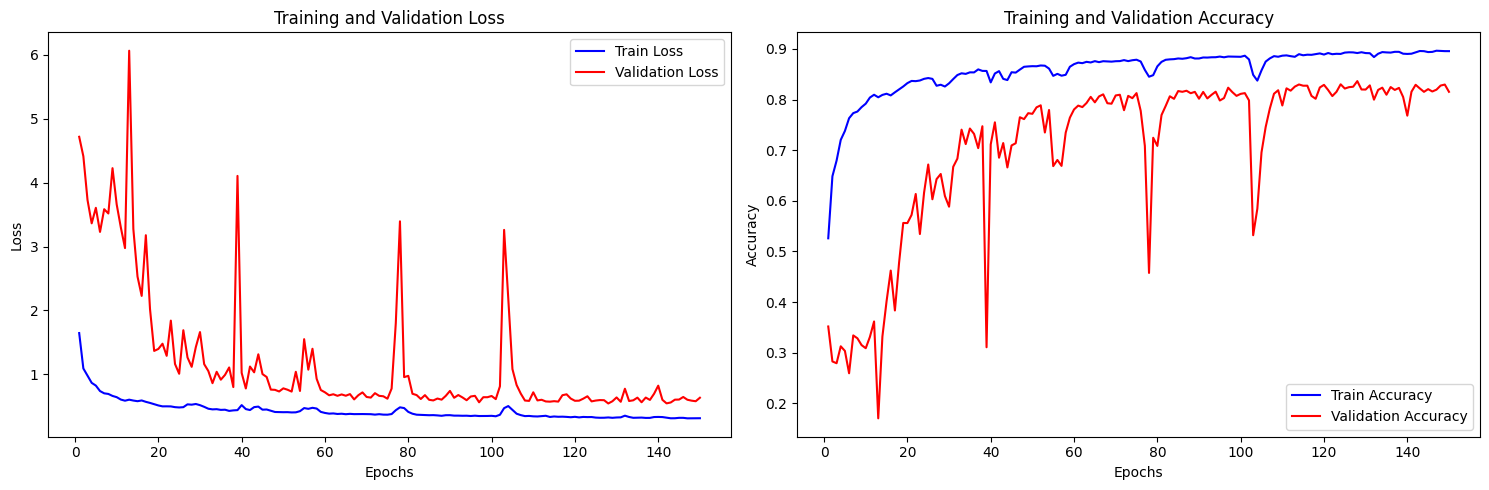

In [ ]:
import matplotlib.pyplot as plt

# Extract the loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Get the number of epochs that were actually run (based on early stopping)
epochs = len(train_loss)

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss
ax1.plot(range(1, epochs + 1), train_loss, label='Train Loss', color='blue')
ax1.plot(range(1, epochs + 1), val_loss, label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(range(1, epochs + 1), train_accuracy, label='Train Accuracy', color='blue')
ax2.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()


### Save model

In [ ]:
# Save the model
model.save('/content/your_model.keras')  # Save in HDF5 format


##6-Conversion to TF-lite
This code converts a Keras model to TFLite for efficient deployment on a Raspberry Pi. It applies integer quantization to reduce model size, improve speed, and lower power usage. The converted .tflite model runs optimized int8 operations, making inference much faster compared to using a full TensorFlow model.

In [ ]:
import tensorflow as tf

# Load your Keras model
model = tf.keras.models.load_model('your_model.keras')  # or .h5

# Create a TFLiteConverter from the Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set optimization flags for full integer quantization, if desired
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen  # define this generator
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert the model
tflite_quant_model = converter.convert()

# Save the converted model
with open("your_model.tflite", "wb") as f:
    f.write(tflite_quant_model)
